In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [19]:
def draw_sunburst(ontology_table, ggprofile):
    df = pd.read_csv(ontology_table)

    levels = list(df.columns)
    levels.reverse()


    def build_hierarchical_dataframe(df, levels, value_column = None, color_columns=None):
        df_all_trees = pd.DataFrame(columns=['id', 'parent', 'level'])
        for i, level in enumerate(levels):
            df_tree = pd.DataFrame(columns=['id', 'parent'])
            dfg = df.groupby(levels[i:]).sum()
            dfg = dfg.reset_index()
            df_tree['id'] = dfg[level].copy()
            df_tree['level'] = level
            if i < len(levels) - 1:
                df_tree['parent'] = dfg[levels[i+1]].copy()
            else:
                df_tree['parent'] = ''
            df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
        return df_all_trees


    df = build_hierarchical_dataframe(df, levels)
    gprofile = pd.read_csv(ggprofile)
    df = df.set_index(["id"])
    gprofile = gprofile.set_index(['term_id'])
    df = df.join(gprofile, how = "inner")
    df = df.reset_index()[['level', 'index', 'parent', 'term_name', \
                           'negative_log10_of_adjusted_p_value', 'intersection_size', "intersections"]]
    df = df.drop_duplicates("index")
    df = df.set_index("index")
    
    unique_children_term = df.groupby("parent")['intersections'].agg(lambda x: ",".join(x)).apply(lambda x: set(x.split(",")))[1:]
    unique_children_term = unique_children_term.rename('unique_children_terms')
    df_compare = pd.concat([df, unique_children_term], axis = 1)
    df_compare["intersections"] = df_compare["intersections"].apply(lambda x : set(x.split(",")))
    unique = df_compare.dropna(axis = 'rows').apply(lambda x: x['intersections'].difference(x['unique_children_terms']), axis = 1).apply(lambda x: len(x))

    
    df = pd.concat([df, unique], axis = 1)
    df['value'] = df['intersection_size']
    df.fillna(0, inplace = True)


    for i in [eval(i) for i in levels][:-1]:
        temp_df = df[df['level'] == str(i)].groupby('parent')['value'].sum()
        temp_up_df = df[df['level'] == str(i-1)]
        temp_up_df = temp_up_df.loc[temp_up_df.index.isin(temp_df.index)]
        temp_up_df['value'] = temp_df.loc[temp_up_df.index]
        temp_up_df['value'] = temp_up_df['value'] + temp_up_df[0]
        df = df.loc[~df.index.isin(temp_up_df.index)]
        df = pd.concat((df,temp_up_df))
        
    new_index_list = []
    parent_list = []
    term_name_list = []
    negative_log10_of_adjusted_p_value_list = []
    value_new_list = []
    df.reset_index(inplace=True)
    for element in df.dropna()['index'] :
        if df[df['index'] == element].iloc[0, -2]>0:
            new_index_list.append(element + "_pseudo")
            parent_list.append(element)
            term_name_list.append("pseudo_name")
            negative_log10_of_adjusted_p_value_list.append(0)
            value_new_list.append(df[df['index'] == element].iloc[0, -2])
        
    df_pseudo = pd.DataFrame({'index': new_index_list, 'parent': parent_list, 'term_name': term_name_list, 'negative_log10_of_adjusted_p_value': negative_log10_of_adjusted_p_value_list, 'value' : value_new_list})
    df = pd.concat([df[df_pseudo.columns], df_pseudo])
    
    
    fig = go.Figure()
    fig.add_trace(go.Sunburst(
        labels=df['index'],
        parents=df['parent'],
        values = df['value'],
        marker=dict(
            colors=(df['negative_log10_of_adjusted_p_value']),
            colorscale='orrd',
            showscale = False,
            colorbar_len=0.4, colorbar_x=0.8, cmin = 0,colorbar_ticklabelstep=2),
        #hovertext=df['term_name'], 
        branchvalues="total",
        rotation = 60
    ))
    fig.update_layout(uniformtext_minsize=100, uniformtext_mode='hide')
    fig.update_layout(autosize=False,margin = dict(t=0, l=0, r=0, b=0, pad=0), 
                      height = 1000, width = 500)
    config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
      }
    }
    fig.show(config=config)
    


In [21]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/GO_enrichment_analysis/'
draw_sunburst(wdir+'nal_bp_sunburst_prepared.csv', wdir+'NAL_gene_gProfiler.csv')


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



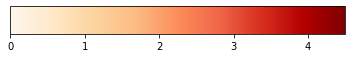

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.OrRd
norm = mpl.colors.Normalize(vmin=0, vmax=4.5)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=np.arange(0,5,1))
cb1.set_label('')
fig.show()

In [ ]:
mpl.cm.OrRd